In [1]:
import pandas as pd
import sys
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import numpy as np

ServerName = "localhost"
Database = "SQLBook"

# Create the connection
engine = create_engine('postgresql://postgres:@' + ServerName + ':5432/' + Database)

In [2]:
# repeatable random sampling
sql = '''
SELECT setseed(0.5);
SELECT *
FROM customers c 
-- (1) For every row, a random number between 0 and 1 is generated. If this number is less than 0.1, it is selected. Otherwise, it is not.
WHERE random() < 0.1
'''

df = pd.read_sql_query(sql, engine)


In [3]:
df[:5]

,customerid,householdid,gender,firstname
0,138942,36422407,M,RICHARD
1,16268,19767590,M,JOHN
2,174623,53956468,F,JEANNETTE
3,147596,24613744,M,JACQUES
4,174812,53978877,F,JEAN-PAUL


In [17]:
# tablesample system
sql = '''
SELECT * 
FROM customers 
TABLESAMPLE SYSTEM_ROWS(1000)
'''

df = pd.read_sql_query(sql, engine)
df[:5]

,customerid,householdid,gender,firstname
0,86099,18971646,F,KAREN
1,12542,19392952,M,PETER
2,534,19124064,,T.
3,81287,36182513,F,EVE
4,23177,18836805,M,GARY


In [18]:
# balanced sampleing
sql = '''
WITH cust AS (
    SELECT c.*,
        -- Assign the same row number for all rows with the same value of isF
        ROW_NUMBER() OVER (PARTITION BY isF) AS seqnum
    FROM (SELECT c.*,
        (CASE WHEN c.gender = 'F' THEN 1 ELSE 0 END) AS isF
         FROM customers c
         WHERE c.gender <> ''
         ) c
    )
SELECT 
    SUM(CASE WHEN cust.isF = 1 THEN 1 ELSE 0 END) * 100 / COUNT(*) AS percent_f,
    SUM(CASE WHEN cust.isF = 0 THEN 1 ELSE 0 END) * 100 / COUNT(*) AS percent_m,
    COUNT(*) AS total_count
FROM cust
WHERE seqnum <= 500

'''
df = pd.read_sql_query(sql, engine)
df[:5]

,percent_f,percent_m,total_count
0,50,50,1000


In [ ]:
# stratified sampling - not working in notebook
sql = '''
WITH cust AS (
        SELECT c.*, ROW_NUMBER() OVER (ORDER BY c.gender) AS rownum
    FROM customers c
    )
SELECT 
SUM(CASE WHEN cust.gender = 'F' THEN 1 ELSE 0 END) * 100 / COUNT(*) AS percent_f,
SUM(CASE WHEN cust.gender = 'M' THEN 1 ELSE 0 END) * 100 / COUNT(*) AS percent_m,
COUNT(*) AS total_count
FROM cust
WHERE cust.rownum  % 100 = 1

'''
df = pd.read_sql_query(sql, engine)
df[:5]

### histogram

In [4]:
def plot_histogram(df, index_column, hist_column, title=None):
    if not title: title = "histgram " + hist_column
    df_indexed = df.set_index(index_column)
    ax = df_indexed[hist_column].plot(kind='bar', title = title, figsize=(15, 8), legend=True, fontsize=12, secondary_y=True)
    ax.set_xlabel(index_column, fontsize=12)
    ax.set_ylabel(hist_column, fontsize=12)
    plt.show()

def plot_histogram_group(df, index_column, hist_columns):
    fig, ax = plt.subplots(len(hist_columns), 1, figsize=(15,10))
    df_indexed = df.set_index(index_column)
    for i,col in enumerate(hist_columns):
        df_indexed[col].plot(ax=ax[i], kind='bar', title ="histgram " + col, legend=True, fontsize=12)
        ax[i].set_xlabel(index_column, fontsize=12)
        ax[i].set_ylabel(col, fontsize=12)
    plt.show()

def plot_histogram_group_scaled(df, index_column, hist_columns, title=None):
    plt.figure(figsize=(15, 6))
    fig, ax = plt.subplots()
    df_scaled = df.set_index(index_column)
    legends = hist_columns.copy()
    for i,col in enumerate(hist_columns):
        legends[i] += ' - max:' + str(df_scaled[col].max())
        df_scaled[col] /= float(df_scaled[col].max())
        
    df_scaled[hist_columns].plot.bar(figsize=(10,6), title=title, ax=ax)
    ax.legend(legends);
    plt.show()
    
def plot_curve(df, x_col, y_col):
    plt.figure(figsize=(10, 6))
    plt.plot(df[x_col], df[y_col])
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

In [5]:
# What is the distribution of orders by state and how is this related to the state’s population?

sql = '''
-- (4) Display the state along with number of orders and population of that state.
SELECT State, SUM(numorders) as numorders, SUM(pop) as pop
FROM (
    -- (1) For each state in orders table, we find the number of orders.
    (SELECT o.State, COUNT(*) as numorders, 0 as pop
    FROM Orders o
    GROUP BY o.state
    ) 
    -- (3) UNION ALL combines all rows in two tables.
    UNION ALL
    -- (2) For each state in zipcensus table, we find the total population.
    (SELECT zc.stab, 0 as numorders, SUM(totpop) as pop
     FROM ZipCensus zc
     GROUP BY zc.stab
    )
) summary
GROUP BY State
-- (5) Arrange the rows in descending order of number of orders
ORDER BY numorders DESC
'''
df = pd.read_sql_query(sql, engine)
df[:5]

,state,numorders,pop
0,NY,53537.0,19382371.0
1,NJ,21274.0,8793873.0
2,CA,17839.0,37315886.0
3,FL,10185.0,18884900.0
4,CT,9369.0,3572213.0


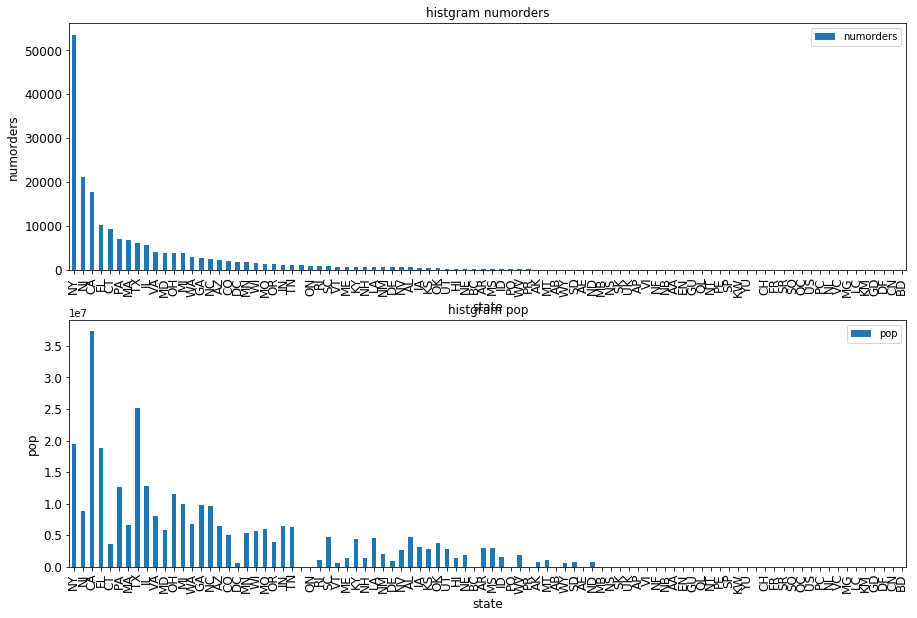

In [18]:
plot_histogram_group(df, 'state', ['numorders', 'pop'])

In [15]:
# Histograms (Frequencies) for Numeric Values
# Ex: How many different values does totalprice take on?
# * TotalPrice has over 4,000 values
# * Solution: Group them into ranges
sql = '''
SELECT SIGN(numol) * POWER(2, numol - 1) as lowerbound,
    POWER(2, numol) as upperbound, 
    COUNT(*) as numorders
FROM (
    SELECT o.orderid, FLOOR(1 + LOG(count(1)) / LOG(2)) as numol
    FROM orders o, orderlines ol
    WHERE o.orderid = ol.orderid
    GROUP BY o.orderid
) a
GROUP BY numol
ORDER BY numol
'''
df = pd.read_sql_query(sql, engine)

In [16]:
df[:10]

,lowerbound,upperbound,numorders
0,1.0,2.0,139561
1,2.0,4.0,45552
2,4.0,8.0,7063
3,8.0,16.0,733
4,16.0,32.0,55
5,32.0,64.0,16
6,64.0,128.0,2
7,128.0,256.0,1


In [19]:
# What is the number of order lines where the product occurs once (overall), twice, and so on?

sql = '''
-- (2) Group by number of order lines and find the product count
SELECT numol, COUNT(*) as numprods, MIN(ProductId), MAX(ProductId)
FROM (
    -- (1) Find the number of order lines where each product appears - group by ProductId
    SELECT ProductId, COUNT(*) as numol
    FROM OrderLines
    GROUP BY ProductId
) op
GROUP BY numol
ORDER BY numol
'''
df = pd.read_sql_query(sql, engine)

In [20]:
df[:3]

,numol,numprods,min,max
0,1,933,10017,14040
1,2,679,10028,14036
2,3,401,10020,14013


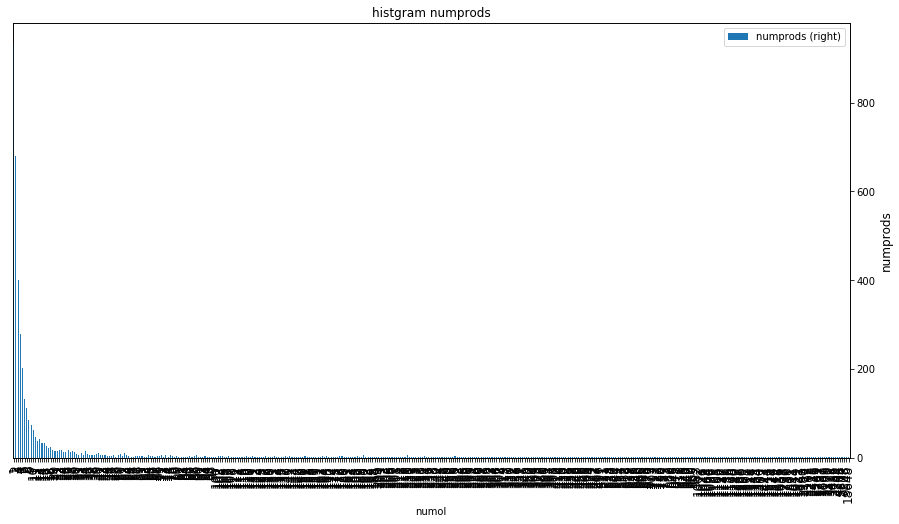

In [22]:
plot_histogram(df, 'numol', 'numprods')

In [5]:
# Cumulative Histograms of Counts
# Ex: What proportion of products account for half of all order lines?
sql = '''
WITH counts AS (
    -- (2) Group by number of order lines and find the product count
    SELECT numol, COUNT(*) as numprods, 
    -- (4) Find cumulative number of order lines. 
    SUM(COUNT(*) * numol) OVER (ORDER BY numol) AS cumulative_numol, 
    -- (3) Find cumulative number of products.
    SUM(COUNT(*)) OVER (ORDER BY numol) AS cumulative_numprods
    FROM (
    -- (1) Find the number of order lines where each product appears
        SELECT ProductId, COUNT(*) as numol
        FROM OrderLines
        GROUP BY ProductId
    ) op
    GROUP BY numol
    ORDER BY numol
)
SELECT numol, numprods, cumulative_numol, cumulative_numprods, 
-- (5) Convert the cumulative sums to percentage
    (cumulative_numol/286017 * 100)::decimal(5,1) AS percentage_cumulative_numol, 
    (cumulative_numprods/4040 * 100)::decimal(5,1) AS percentage_cumulative_numprods
FROM counts
'''
df = pd.read_sql_query(sql, engine)

In [6]:
df[:3]

,numol,numprods,cumulative_numol,cumulative_numprods,percentage_cumulative_numol,percentage_cumulative_numprods
0,1,933,933.0,933.0,0.3,23.1
1,2,679,2291.0,1612.0,0.8,39.9
2,3,401,3494.0,2013.0,1.2,49.8


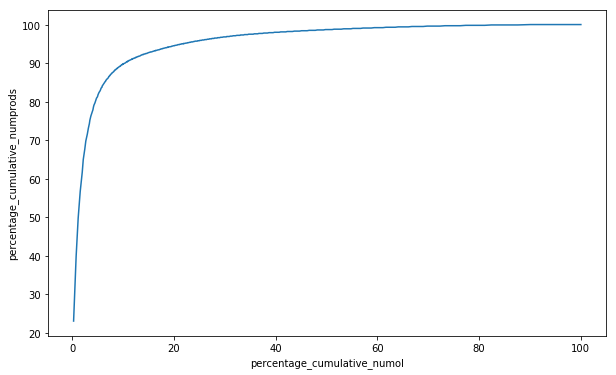

In [7]:
plot_curve(df, 'percentage_cumulative_numol', 'percentage_cumulative_numprods')

In [37]:
# Histograms (Frequencies) for Numeric Values
# Ex: How many different values does totalprice take on?
# * TotalPrice has over 4,000 values
# * Solution: Group them into ranges
sql = '''
SELECT SIGN(numdigits) * POWER(10, numdigits - 1) as lowerbound,
    POWER(10, numdigits) as upperbound, 
    COUNT(*) as numorders, 
    MIN(TotalPrice) as min_totalprice, 
    MAX(TotalPrice) as max_totalprice
FROM (
    SELECT (CASE WHEN TotalPrice::decimal(10,2) >= 1 THEN FLOOR(1 + LOG(TotalPrice::decimal(10,2)) / LOG(10))
        WHEN -1 < TotalPrice::decimal(10,2) AND TotalPrice::decimal(10,2) < 1 THEN 0
        ELSE - FLOOR(1 + LOG(-TotalPrice::decimal(10,2)) / LOG(10)) END
    ) as numdigits, TotalPrice
    FROM Orders o
) a
GROUP BY numdigits
ORDER BY numdigits
'''
df = pd.read_sql_query(sql, engine)

In [39]:
df

,lowerbound,upperbound,numorders,min_totalprice,max_totalprice
0,0.0,1.0,9130,$0.00,$0.64
1,1.0,10.0,6718,$1.75,$9.99
2,10.0,100.0,148121,$10.00,$99.99
3,100.0,1000.0,28028,$100.00,$999.00
4,1000.0,10000.0,986,"$1,000.00","$9,848.96"


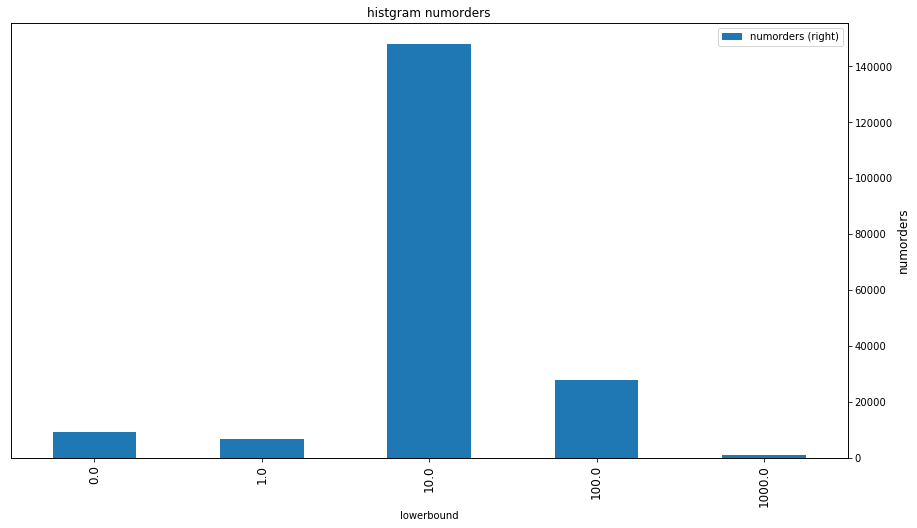

In [38]:
plot_histogram(df, 'lowerbound', 'numorders')

In [40]:
# equal-sized groups
# Int width_bucket(numeric op, numeric b1, numeric b2, int count) 
# Ex: Divide the product data into 10 equal price buckets and draw a histogram depicting the number of products that fall into each of these price buckets. For simplicity, consider products with price less than $1000.

sql = '''
WITH p_1000 AS (
    -- (1) Filter out the products with price > $1000
    SELECT p.*
    FROM products p
    WHERE fullprice::decimal(10,1) <= 1000
),
p_minmax AS ( 
    -- (2) Find the min and max price of the current distribution
    SELECT MIN(fullprice::DECIMAL(10,1)) AS min_price,
       MAX(fullprice::DECIMAL(10,1)) AS max_price
    FROM p_1000
)
-- (3) The data in the range min_price to max_price is divided into 10 + 1 buckets. Find the bucket to which the price of each product belongs to. And group them by buckets.
SELECT WIDTH_BUCKET(fullprice::DECIMAL(10,1), min_price, max_price, 10) AS bucket,
      MIN(fullprice::DECIMAL(10,1)) as min_price, MAX(fullprice::DECIMAL(10,1)) as max_price,
      COUNT(*) AS freq
    FROM p_1000, p_minmax
GROUP BY bucket
ORDER BY bucket
'''
df = pd.read_sql_query(sql, engine)

In [41]:
df

,bucket,min_price,max_price,freq
0,1,0.0,99.0,834
1,2,100.0,195.0,820
2,3,200.0,296.0,63
3,4,300.0,396.0,1122
4,5,405.0,499.0,382
5,6,500.0,598.0,342
6,7,600.0,693.0,107
7,8,700.0,795.0,152
8,9,800.0,862.0,29
9,10,900.0,990.0,20


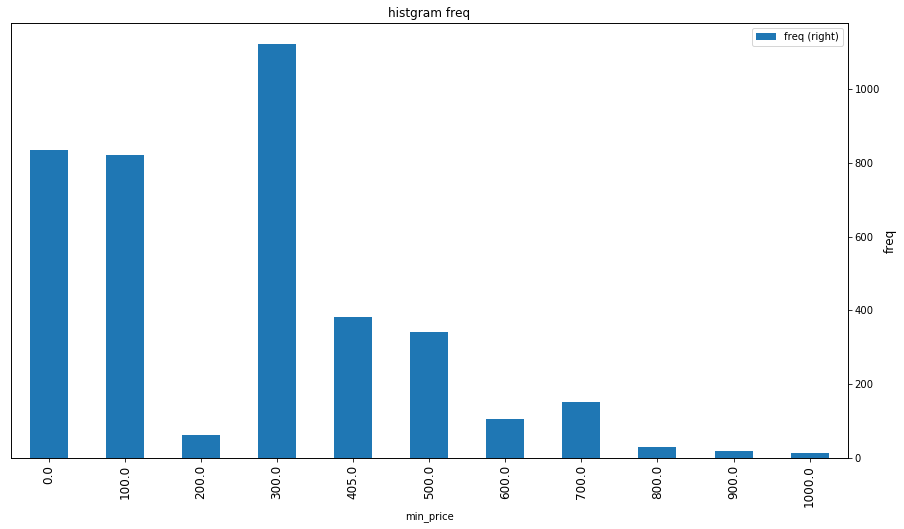

In [42]:
plot_histogram(df, 'min_price', 'freq')

## What are the questions that we can ask the data?
Which books or book categories should be used for demand analysis?
 Let’s say we choose the category (how?)
 
 
* Books/Education & Teaching/Higher & Continuing Education/
  * Should we include all books under this category? 
  * Should we select a subset by price, sales, number of reviews, average rating?
  * Should we consider all sales?
  * Should we consider gift seasons?
  * Should we consider all reviews? 
  * Eliminate really short reviews? 
  * Only consider reviews with some specific expressions in them?
  * Eliminate reviews that are from reviewers who give high (or low) recommendation to too many books?
  * Eliminate low reviews where the only negative factor is price and not content?


### Data Exploration with histogram
product sale volumn: number_orders, number_products, number_total_price

vs

1. price ranges 
2. sales (campaign)
3. calendar (holiday vs nonholiday, different holidaytype)
4. (missing) categories
  * product's category is mostly one category per one product. Need a proper level of aggregation of categories for statistics. (requirement to Integration team)
5. (missing) reviews(incomplete)
  * number of reviews
  * average rating of reviews

In [4]:
sql = '''
WITH p_1000 AS (
    -- (1) Filter out the products with price > $1000
    SELECT p.*
    FROM products p
    WHERE fullprice::decimal(10,1) <= 1000
),
p_minmax AS ( 
    -- (2) Find the min and max price of the current distribution
    SELECT MIN(fullprice::DECIMAL(10,1)) AS min_price,
       MAX(fullprice::DECIMAL(10,1)) AS max_price
    FROM p_1000
)
-- (3) The data in the range min_price to max_price is divided into 10 + 1 buckets. Find the bucket to which the price of each product belongs to. And group them by buckets.
SELECT WIDTH_BUCKET(fullprice::DECIMAL(10,1), min_price, max_price, 10) AS bucket,
      MIN(fullprice::DECIMAL(10,1)) as min_price, MAX(fullprice::DECIMAL(10,1)) as max_price,
      COUNT(distinct(p_1000.productid)) AS product_count,
      COUNT(distinct(o.orderid)) AS order_count,
      COUNT(1) AS copy_count,
      --SUM(ol.numunits * p_1000.fullprice) AS total_value
      CAST(SUM(ol.numunits * p_1000.fullprice) AS decimal(34,0)) AS total_value
FROM p_1000, p_minmax, orders o, orderlines ol
WHERE p_1000.productid = ol.productid AND o.orderid = ol.orderid
GROUP BY bucket
ORDER BY bucket
'''
df = pd.read_sql_query(sql, engine)

In [5]:
df

,bucket,min_price,max_price,product_count,order_count,copy_count,total_value
0,1,0.0,99.0,834,169684,250149,7971575.0
1,2,100.0,195.0,820,17583,21508,4044169.0
2,3,200.0,296.0,63,517,591,125940.0
3,4,300.0,396.0,1122,6022,8072,2600477.0
4,5,405.0,499.0,382,1092,1571,687919.0
5,6,500.0,598.0,342,1405,1983,945325.0
6,7,600.0,693.0,107,318,426,254844.0
7,8,700.0,795.0,152,398,608,358160.0
8,9,800.0,862.0,29,91,111,76965.0
9,10,900.0,990.0,20,179,183,163345.0


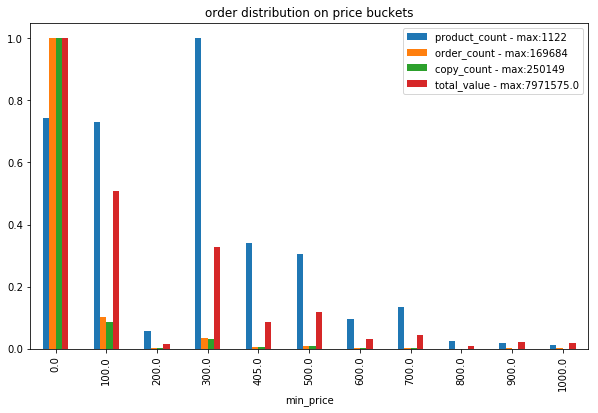

In [8]:
plot_histogram_group_scaled(df, 'min_price', ['product_count', 'order_count', 'copy_count', 'total_value'], title="order distribution on price buckets")

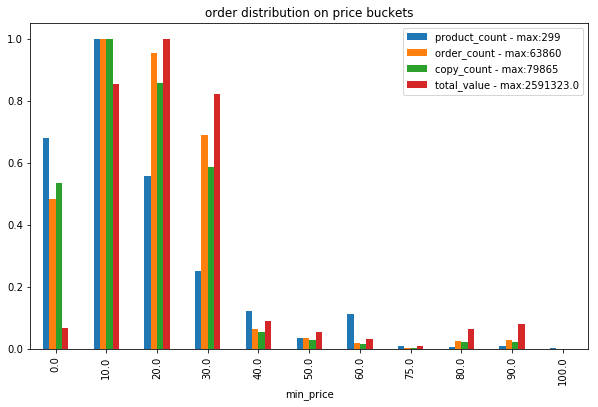

In [10]:
# zoom In $0 ~ 100
sql = '''
WITH p_100 AS (
    -- (1) Filter out the products with price > $1000
    SELECT p.*
    FROM products p
    WHERE fullprice::decimal(10,1) <= 100
),
p_minmax AS ( 
    -- (2) Find the min and max price of the current distribution
    SELECT MIN(fullprice::DECIMAL(10,1)) AS min_price,
       MAX(fullprice::DECIMAL(10,1)) AS max_price
    FROM p_100
)
-- (3) The data in the range min_price to max_price is divided into 10 + 1 buckets. Find the bucket to which the price of each product belongs to. And group them by buckets.
SELECT WIDTH_BUCKET(fullprice::DECIMAL(10,1), min_price, max_price, 10) AS bucket,
      MIN(fullprice::DECIMAL(10,1)) as min_price, MAX(fullprice::DECIMAL(10,1)) as max_price,
      COUNT(distinct(p_100.productid)) AS product_count,
      COUNT(distinct(o.orderid)) AS order_count,
      COUNT(1) AS copy_count,
      --SUM(ol.numunits * p_100.fullprice) AS total_value
      CAST(SUM(ol.numunits * p_100.fullprice) AS decimal(34,0)) AS total_value
FROM p_100, p_minmax, orders o, orderlines ol
WHERE p_100.productid = ol.productid AND o.orderid = ol.orderid
GROUP BY bucket
ORDER BY bucket
'''
df = pd.read_sql_query(sql, engine)
plot_histogram_group_scaled(df, 'min_price', ['product_count', 'order_count', 'copy_count', 'total_value'], title="order distribution on price buckets")

### order volumn VS price
* most volumn: < \$100
* most profitable: \$100~200, 300~400
* < \$100 zoomIn: \$10~40


In [72]:
### View of distribution of sale volumn on campaigns
sql = '''
SELECT cp.channel,
      COUNT(o.orderid) AS order_count,
      CAST(SUM(o.totalprice) AS decimal(34,0)) AS total_value
FROM campaigns cp, orders o
WHERE cp.campaignid = o.campaignid 
GROUP BY cp.channel
ORDER BY order_count DESC
'''
df = pd.read_sql_query(sql, engine)

In [63]:
df

,channel,order_count,total_value
0,PARTNER,84518,6069828.0
1,WEB,53362,4764937.0
2,AD,40652,2245952.0
3,INSERT,7333,200453.0
4,REFERRAL,2550,152065.0
5,MAIL,1755,65589.0
6,BULK,1295,73569.0
7,CATALOG,710,61657.0
8,EMPLOYEE,642,48989.0
9,EMAIL,128,11061.0


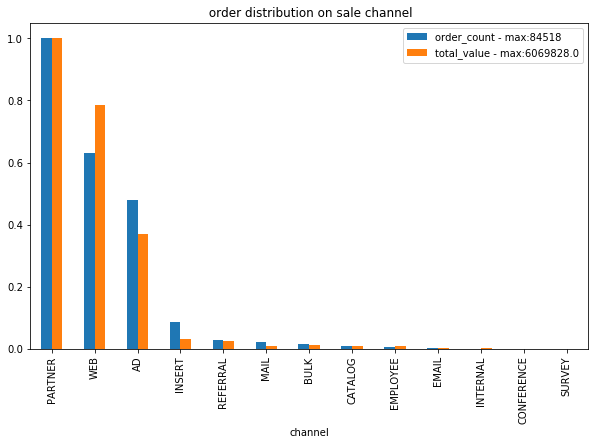

In [65]:
plot_histogram_group_scaled(df, 'channel', ['order_count', 'total_value'], title=" order distribution on sale channel")

### order volumn VS sales
Big three channels


In [108]:
### distribution of sale volumn on holidays
sql = '''
SELECT ca.holidaytype,
      COUNT(distinct(ca.date)) AS days,
      COUNT(o.orderid) AS order_count,
      CAST(SUM(o.totalprice) AS decimal(34,0)) AS total_value
FROM calendar ca, orders o
WHERE ca.date = o.orderdate 
GROUP BY ca.holidaytype
ORDER BY order_count DESC
'''
df = pd.read_sql_query(sql, engine)

In [109]:
df['value_per_day'] = df['total_value'] / df['days']
df

,holidaytype,days,order_count,total_value,value_per_day
0,,2288,173717,12440516.0,5437.288462
1,minor,63,5479,335733.0,5329.095238
2,national,63,4666,345621.0,5486.047619
3,jewish,51,4091,249290.0,4888.039216
4,other,35,2507,155262.0,4436.057143
5,muslim,14,1252,88042.0,6288.714286
6,christian,21,904,65540.0,3120.952381
7,chinese,6,367,28892.0,4815.333333


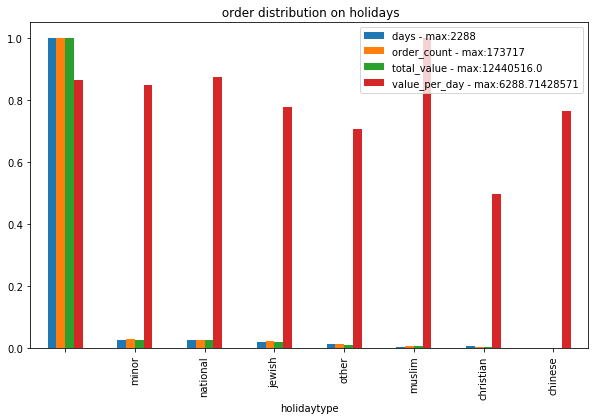

In [110]:
plot_histogram_group_scaled(df, 'holidaytype', ['days', 'order_count', 'total_value', 'value_per_day'], title=" order distribution on holidays")

### order volumn holidays vs non-holidays
no significance

In [86]:
### distribution of sale volumn on months
sql = '''
SELECT ca.month,
      COUNT(distinct(ca.date)) AS days,
      COUNT(o.orderid) AS order_count,
      CAST(SUM(o.totalprice) AS decimal(34,0)) AS total_value
FROM calendar ca, orders o
WHERE ca.date = o.orderdate 
GROUP BY ca.month
ORDER BY ca.month
'''
df = pd.read_sql_query(sql, engine)

In [87]:
df

,month,days,order_count,total_value
0,1,217,19180,1094024.0
1,2,195,10924,774563.0
2,3,217,12170,995490.0
3,4,210,10879,866171.0
4,5,217,12431,1040686.0
5,6,210,15075,1093346.0
6,7,217,11010,978743.0
7,8,217,13321,863012.0
8,9,200,12329,780109.0
9,10,214,14166,882276.0


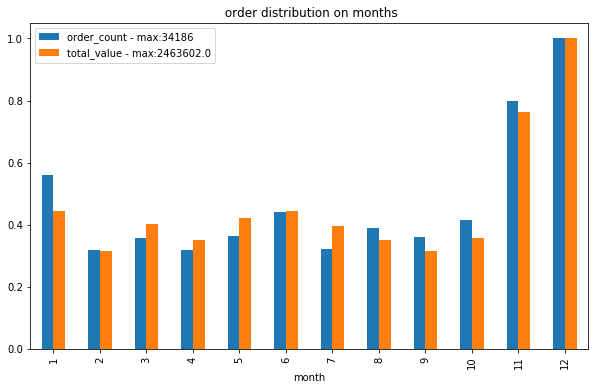

In [88]:
plot_histogram_group_scaled(df, 'month', ['order_count', 'total_value'], title=" order distribution on months")

### order volumn VS month
big volumn on Nov. Dec


In [105]:
### order volumn vs zip population
sql = '''
WITH zip_volumn as (SELECT zc.zcta5,
      COUNT(o.orderid) AS order_count,
      CAST(SUM(o.totalprice) AS decimal(34,0)) AS total_value
FROM zipcensus zc, orders o
WHERE zc.zcta5 = o.zipcode
GROUP BY zc.zcta5
)
SELECT z.state,
       SUM(zc.totpop) AS population,
       SUM(order_count) AS total_order_count,
       SUM(total_value) AS sum_total_value
FROM zip_volumn, zipcensus zc, zipcounty z
WHERE zc.zcta5 = zip_volumn.zcta5 AND zc.zcta5 = z.zipcode
GROUP BY z.state
ORDER BY total_order_count DESC
LIMIT 20
'''
df = pd.read_sql_query(sql, engine)

In [106]:
df['avg_order'] = df['total_order_count'] / df['population']
df[:5]

,state,population,total_order_count,sum_total_value,avg_order
0,NY,18163208,52919.0,3671889.0,0.002914
1,NJ,8483752,20963.0,1415115.0,0.002471
2,CA,31167628,17426.0,1490345.0,0.000559
3,FL,15886804,9821.0,611140.0,0.000618
4,CT,3386694,8774.0,599581.0,0.002591


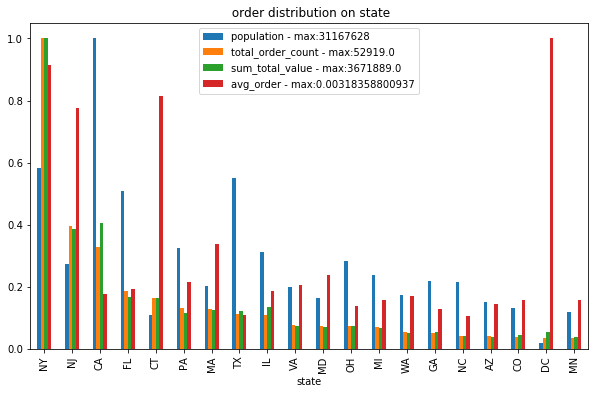

In [107]:
plot_histogram_group_scaled(df[df['total_order_count']>1000], 'state', ['population', 'total_order_count', 'sum_total_value', 'avg_order'], title=" order distribution on state")

### order volumn VS states
* big pop, low volumn: CA
* small pop, huge avg volumn: DC
* big pop and volumn: NY


### project goal - make recommendation
But
* recommend what  -- product
* to who?         -- customer
* at what time?   -- calendar
* in what format? -- campaigns(sale)

## Preliminary queries that for ML
* Preliminary queries that're potentially useful for ML based on our view.
* Features from raw data with qualification criteria
* Aggregated features from raw data - todo

## Query conditions

### Queries w.r.t products
1. whose category name contains the string “Education” and 
    must be at least two levels below “Books” (why?) AND 
2. the price of the book is between \$20 and \$60 (why?) AND
3. the book must have an average sale of 20 copies/month AND 
4. the book has received at least 10 reviews (why?)
  each of which must have at least three sentences (why?)

`
SELECT p.productid, p.name,  30*sum(ol.numunits) / (max(o.orderdate)-min(o.orderdate)) as monthly_volumn
FROM products p, orders o, orderlines ol
WHERE 
  p.fullprice between '20' AND '60' AND
  p.productid = ol.productid and o.orderid = ol.orderid
GROUP BY p.productid
HAVING  max(o.orderdate)!=min(o.orderdate) AND 30*sum(ol.numunits) / (max(o.orderdate)-min(o.orderdate)) > 20
ORDER BY monthly_volumn DESC
`

### queries w.r.t customers
1. customers with gender male/female, other profile(eg age)?
2. customers who purchased above certain volumn, eg > 5 orders, > 10 books or > $100 total value
3. customers who purchased above certain volumn/period, eg 5 orders/month

2,3 are invalid because each customer purchased only 1 book.

### queries w.r.t campaigns
1. campaigns(239 in total) that produces high volumn, eg > 30 orders
2. campaign channels(13 in total) that produces high volumn. (can be done offline)
3. campaign discount(10 in total) that produces high volumn. (offline)
4. campaign with freeshipping(2) 

### queries w.r.t calendar
1. dates that are in and outside of holidays windows with window's size
2. dates that are in different holidays or holiday types
3. dates of non-holidays that have seasonal high volumn

### queries of combined criterias
1. combine multiple criterias, all criterias are connected through orders.  eg. get orders that 
  * are from high-volumn customers, eg > 5 orders/month
  * include books with high price, eg > $50
  * are sold during winter
  * are sold on web(channel), with no discount, with no freeshipping
      
2. Join scheme
  * inner join
    eg. get orders that are either from high-volumn customers or include books with high price
  * outer join
    eg. get orders that are from high-volumn customers and involve books with high price

## Feature Extraction
Need working with ML team for more detailed requirement

### Single-factor recommendation model
1. neighborhood method 
  * similar to HW 'cats video' in dse201
2. latent factor method
  * customer vs product matrix setup - possible with SQL?


### Comprehensive model with dynamic features 
1. recommendation depends on dynamic input eg, current date is holiday or not, current budget for campaign, etc

2. We can build separate tables for customer features and product features. eg
  * customerid, order_num, avg_order_per_month, total_price, order_percent_in_holiday, order_percent_in_discount, order_percent_in_category1, ...
  * productid, order_num, order_percent_in_holiday, total_review_cnt, avg_review_rate, adjusted_category, ...

3. cross product 2 gives
  * customerid, productid, cust_feature1, cust_feature2, ..., book_feature1, book_feature2, ..., 
